In [366]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [367]:
from math import sqrt
from numpy import concatenate
import glob
from pandas import read_csv, DataFrame, concat, Series

import matplotlib
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, GRU

In [368]:
dataset = read_csv("/content/drive/My Drive/data/sequential_data/traces/features_from_spans.csv", header = 0, index_col = 0)
dataset.head(5)

,wsgi_122,wsgi_122_duration,db_122,db_122_duration,neutron.db_122,neutron.db_122_duration,rpc_122,rpc_122_duration,compute_api_122,compute_api_122_duration,nova_image_122,nova_image_122_duration,neutron_api_122,neutron_api_122_duration,spans_122,spans_122_duration,wsgi_113,wsgi_113_duration,db_113,db_113_duration,neutron.db_113,neutron.db_113_duration,rpc_113,rpc_113_duration,compute_api_113,compute_api_113_duration,nova_image_113,nova_image_113_duration,neutron_api_113,neutron_api_113_duration,spans_113,spans_113_duration,wsgi_124,wsgi_124_duration,db_124,db_124_duration,neutron.db_124,neutron.db_124_duration,rpc_124,rpc_124_duration,...,db_123,db_123_duration,neutron.db_123,neutron.db_123_duration,rpc_123,rpc_123_duration,compute_api_123,compute_api_123_duration,nova_image_123,nova_image_123_duration,neutron_api_123,neutron_api_123_duration,spans_123,spans_123_duration,wsgi_117,wsgi_117_duration,db_117,db_117_duration,neutron.db_117,neutron.db_117_duration,rpc_117,rpc_117_duration,compute_api_117,compute_api_117_duration,nova_image_117,nova_image_117_duration,neutron_api_117,neutron_api_117_duration,spans_117,spans_117_duration,MI_122_113,MI_122_124,MI_122_123,MI_122_117,MI_113_124,MI_113_123,MI_113_117,MI_124_123,MI_124_117,MI_123_117
window,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"[Timestamp('2019-11-19 17:38:39'), Timestamp('2019-11-19 17:39:09')]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79,13560934,706,2646801,0,0,0,0,0,0,0,0,0,0,785,16207735,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.886774,2.904216,2.858006,2.794355,3.014077,2.967867,2.904216,2.985309,2.967867,2.875448
"[Timestamp('2019-11-19 17:39:10'), Timestamp('2019-11-19 17:39:40')]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,20274826,838,1999143,0,0,0,0,0,0,0,0,0,0,954,22273969,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.858006,2.701935,2.950426,2.886774,2.736818,2.939099,2.875448,2.783028,2.719377,2.967867
"[Timestamp('2019-11-19 17:39:41'), Timestamp('2019-11-19 17:40:11')]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,119,18154900,829,1459145,0,0,0,0,0,0,0,0,0,0,948,19614045,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.967867,2.904216,3.170148,3.106497,2.655725,2.921658,2.858006,2.858006,2.794355,3.060287
"[Timestamp('2019-11-19 17:40:12'), Timestamp('2019-11-19 17:40:42')]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,19007856,722,1575957,0,0,0,0,0,0,0,0,0,0,827,20583813,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.932984,2.921658,3.077729,3.077729,2.730703,2.886774,2.886774,2.875448,2.875448,3.031519
"[Timestamp('2019-11-19 17:40:43'), Timestamp('2019-11-19 17:41:13')]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,16339187,615,767330,0,0,0,0,0,0,0,0,0,0,706,17106517,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.886774,2.667052,2.996636,2.811796,2.776913,3.106497,2.921658,2.886774,2.701935,3.031519


In [369]:
names = ['wsgi', 'db', 'neutron.db', 'rpc', 'compute_api', 'nova_image', 'neutron_api']
hosts = ['wally122', 'wally113']
arr_names = ['MI_122_113']
arr_duration = ['MI_122_113']
arr_all = ['MI_122_113']
for host in hosts:
  for name in names:
    arr_names.append(name + '_' + host[host.find('1'):])
    arr_duration.append(name + '_' + host[host.find('1'):] + '_duration')
    arr_all.append(name + '_' + host[host.find('1'):] + '_duration')
    arr_all.append(name + '_' + host[host.find('1'):])

ds1 = dataset[['MI_122_113', 'spans_122', 'spans_113']]
ds2 = dataset[['MI_122_113', 'spans_122_duration', 'spans_113_duration']]
ds3 = dataset[['MI_122_113', 'spans_122', 'spans_113', 'spans_122_duration', 'spans_113_duration']]
ds4 = dataset[arr_names]
ds5 = dataset[arr_duration]
ds6 = dataset[arr_all]

In [370]:
def plotAllColumns(dataset):
  values = dataset.values
  fig, axes = plt.subplots(len(dataset.columns), 1, figsize=(20, 2.5 * len(dataset.columns)))

  for i in range(len(axes)):
    axes[i].plot(values[:, i])
    axes[i].set_title(dataset.columns[i], fontsize = 14)

  plt.subplots_adjust(hspace = 0.4)
  plt.show()

In [371]:
# convert series to supervised learning
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace = True)
	return agg

def prepareData(dataset):
  # ensure all data is float
  values = dataset.values
  values = values.astype('float64')
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[list(range(len(dataset.columns) + 1, 2 * len(dataset.columns)))], axis = 1, inplace = True)
  return reframed, scaler

In [372]:
def prepareTestAndTrainData(reframed):
  # split into train and test sets
  values = reframed.values
  n_train_values = int(len(values) * 0.8)
  train = values[:n_train_values, :]
  test = values[n_train_values:, :]
  # split into input and outputs
  train_X, train_Y = train[:, :-1], train[:, -1]
  test_X, test_Y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  return train_X, train_Y, test_X, test_Y

In [373]:
def createModel(train_X, train_Y, test_X, test_Y):
  # design network
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss = 'mae', optimizer = 'adam')
  # fit network
  history = model.fit(train_X, train_Y, epochs = 50, batch_size = 64, validation_data = (test_X, test_Y), verbose = 0, shuffle = False)
  # plot history
  #fig, axes = plt.subplots(1, 1, figsize=(7, 7))
  #plt.plot(history.history['loss'], label = 'train')
  #plt.plot(history.history['val_loss'], label = 'test')
  #plt.legend()
  #plt.show()
  return model

In [374]:
def makePrediction(model, scaler, test_X, test_Y):
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  # invert scaling for forecast
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis = 1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_Y = test_Y.reshape((len(test_Y), 1))
  inv_y = concatenate((test_Y, test_X[:, 1:]), axis = 1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  # calculate evaluation
  print('Test MSE: %.3f' % mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % sqrt(mean_squared_error(inv_y, inv_yhat)))
  print('Test MAE: %.3f' % mean_absolute_error(inv_yhat, inv_y))
  #print('Test R^2: %.3f' % r2_score(inv_y, inv_yhat))
  return inv_y, inv_yhat

In [375]:
def printOriginalPrediction(inv_y, inv_yhat):
  result = concat([Series(inv_y),Series(inv_yhat)], axis = 1)
  result.columns = ['original','prediction']
  result['diff'] = result['original'] - result['prediction']
  print(result)

In [376]:
def plotOriginalPrediction(inv_y, inv_yhat, title):
  fig, axes = plt.subplots(1, 1, figsize=(20, 4))
  plt.plot(inv_y, color = '#3949AB', label = "original")
  plt.plot(inv_yhat, color = '#F4511E', label = "prediction")
  plt.title(title, fontsize = 18)
  plt.legend()
  #plt.xlim(0, 100)
  #plt.ylim(2.3, 3.4)
  plt.tight_layout()
  plt.show()

In [377]:
def predictAlgo(dataset, title):
  #plotAllColumns(dataset)
  data, scaler = prepareData(dataset)
  train_X, train_Y, test_X, test_Y = prepareTestAndTrainData(data)
  model = createModel(train_X, train_Y, test_X, test_Y)
  inv_y, inv_yhat = makePrediction(model, scaler, test_X, test_Y)
  #printOriginalPrediction(inv_y, inv_yhat)
  plotOriginalPrediction(inv_y, inv_yhat, title)

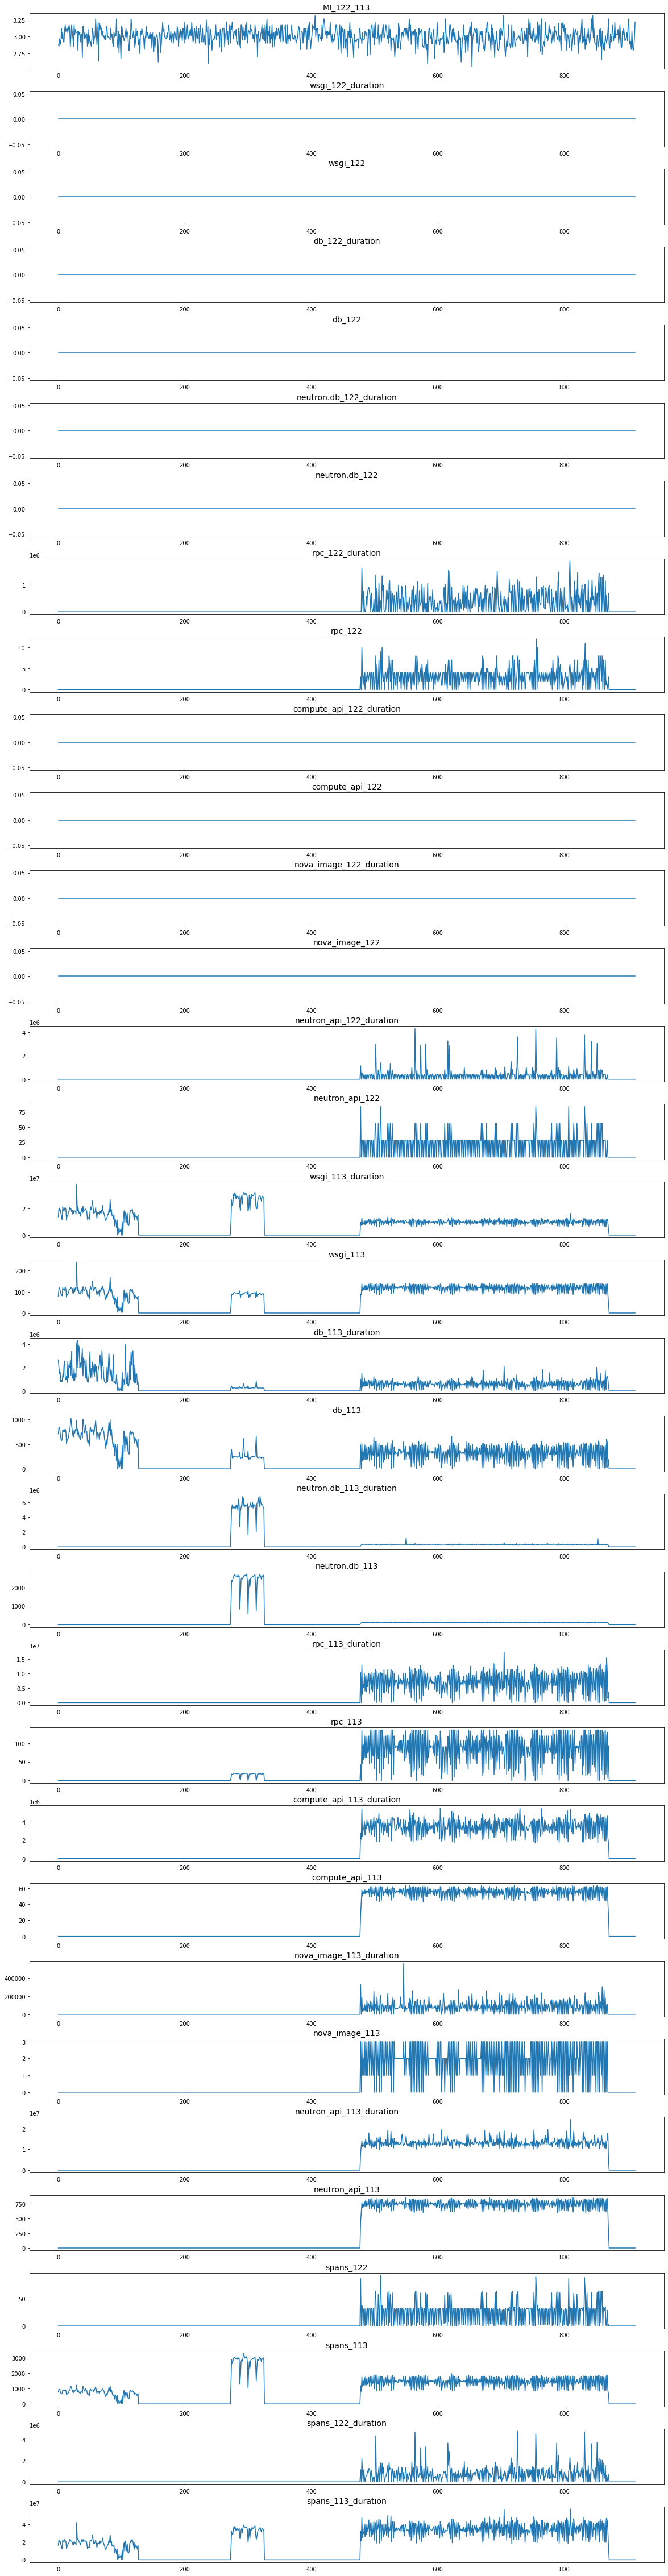

In [378]:
plotAllColumns(dataset[arr_all + ['spans_122', 'spans_113', 'spans_122_duration', 'spans_113_duration']])

Test MSE: 0.016
Test RMSE: 0.125
Test MAE: 0.098


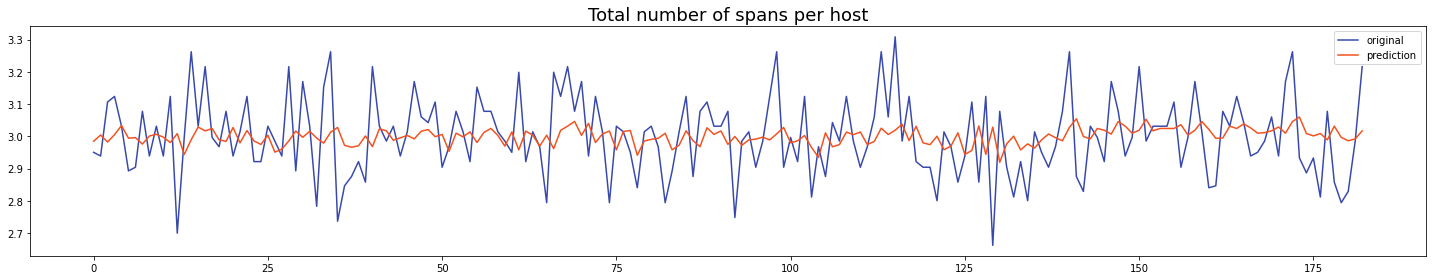

Test MSE: 0.016
Test RMSE: 0.125
Test MAE: 0.098


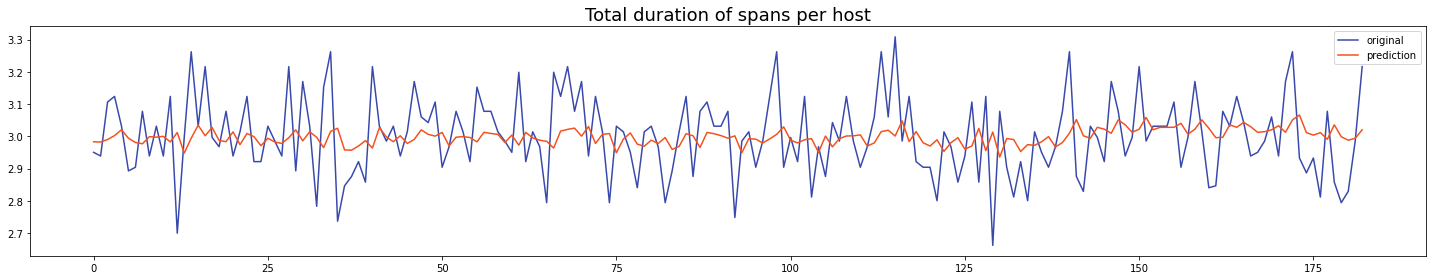

Test MSE: 0.016
Test RMSE: 0.125
Test MAE: 0.099


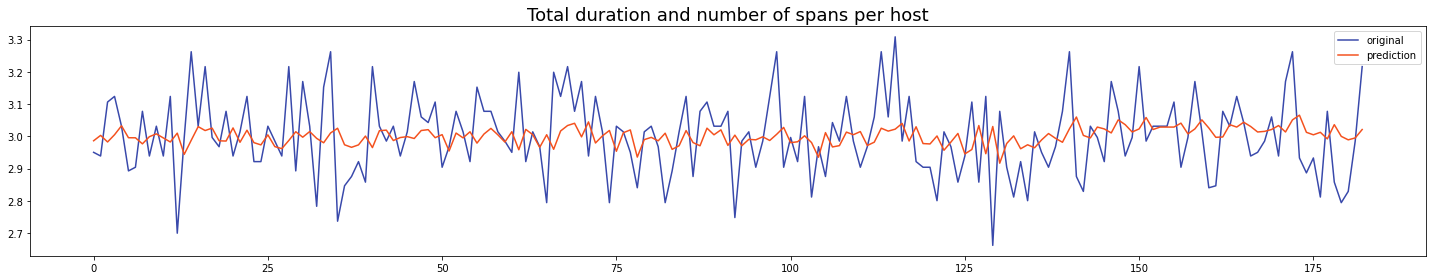

Test MSE: 0.016
Test RMSE: 0.125
Test MAE: 0.099


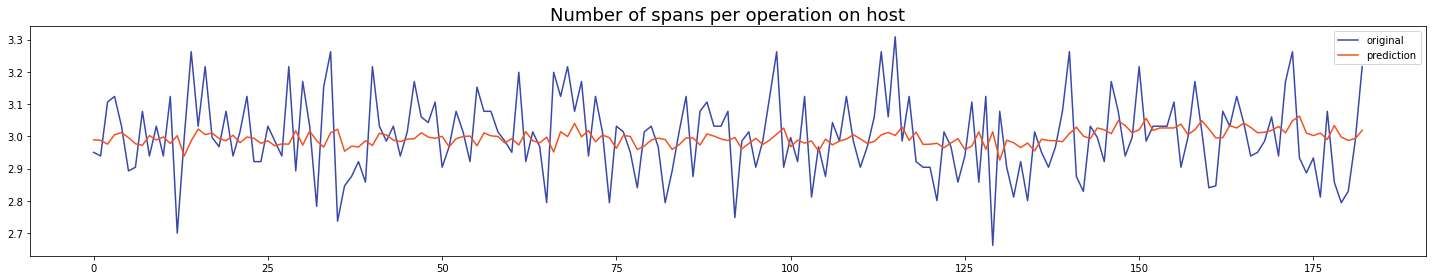

Test MSE: 0.016
Test RMSE: 0.127
Test MAE: 0.101


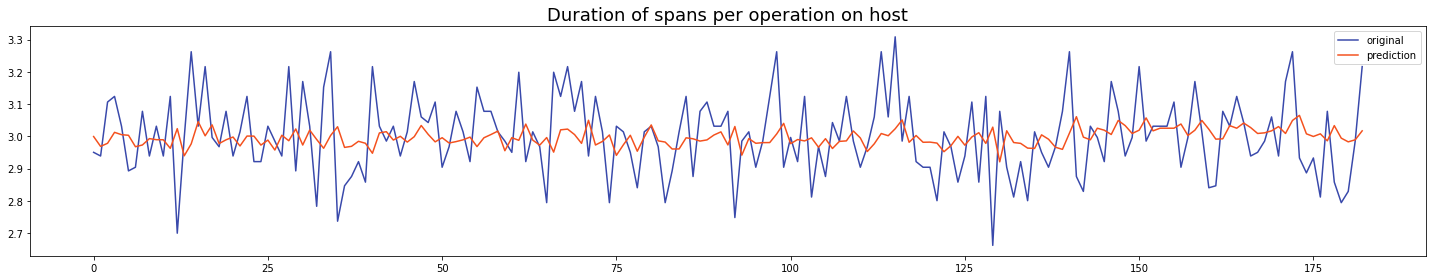

Test MSE: 0.016
Test RMSE: 0.126
Test MAE: 0.100


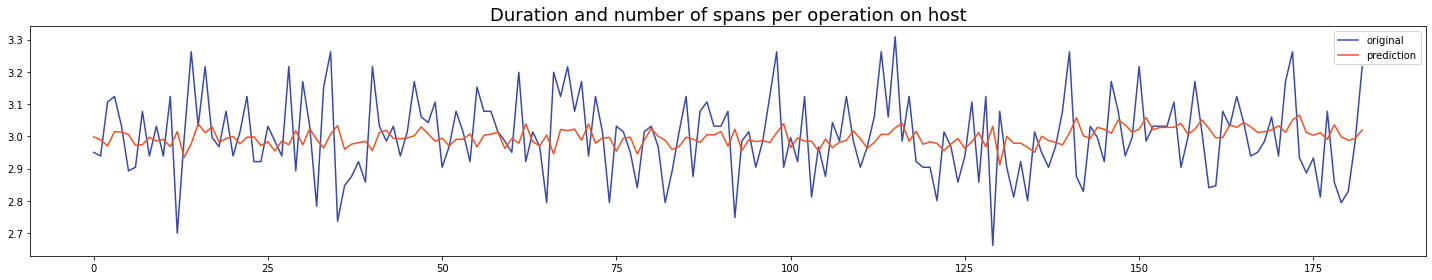

In [379]:
titles = ['Total number of spans per host', 'Total duration of spans per host', 'Total duration and number of spans per host',
          'Number of spans per operation on host', 'Duration of spans per operation on host', 'Duration and number of spans per operation on host']
datasets = [ds1, ds2, ds3, ds4, ds5, ds6]

for i in range(len(datasets)):
  predictAlgo(datasets[i], titles[i])